In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
import numpy as np
import datetime
import pandas as pd
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import time
import glob
import os
import pytz
from tqdm import tqdm
import csv
import matplotlib.dates as mdates
import csv
import re
from TMfunctions import *



In [2]:
#The goal for this notebook is run TM  EFFICIENTly -OPENING just time all files
#we will use just a few templates an hour hour data, and see what happend


# Read the content of the file
with open("converted_dates_and_values_rainier_5days.txt", "r") as file:
    content = file.readlines()

# Parse the content and create a list of lists
data = [line.strip().split() for line in content]

# Convert the list of lists to a NumPy array
array_data = np.array(data)

id_and_dates = array_data


#fecha = id_and_dates[4][1]
#fecha


/tmp/ipykernel_3437888/1597743167.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array_data = np.array(data)


In [3]:
#loading data to run

file_list1 = glob.glob("/data/fast1/veronica-scratch-rainier-downsampling/drive1_ds/new_decimator_2023-08-30*")
file_list2 = glob.glob("/data/fast1/veronica-scratch-rainier-downsampling/drive1_ds/new_decimator_2023-08-31*")
file_list = file_list1 + file_list2

file_list.sort()

In [4]:
#loading templates

template_list = glob.glob('/data/data4/veronica-scratch-rainier/templates-files/*')


In [5]:
# Base directory to save files
base_directory = '/data/data4/veronica-scratch-rainier/test_corr'
#the folder contain in the name_numbers date of the template used

#base_directory = '/home/velgueta/notebooks/RainierDas' #test

corrs = "corrs"
#temp = "informacion de la ultima parte de cada template"

daystart = file_list[0]
dayend = file_list[-1]

# Extract date, hour, and minute portion from file path, excluding "new" and "decimator"
daystart_parts = os.path.basename(daystart).split('_')
daystart_date_time = "_".join(daystart_parts[2:4])  # Extract the date and time parts, excluding "new_decimator" and "UTC.h5"

dayend_parts = os.path.basename(dayend).split('_')
dayend_date_time = "_".join(dayend_parts[2:4])  # Extract the date and time parts, excluding "new_decimator" and "UTC.h5"

chan_min = 1000
chan_max = 2500
channel_number = chan_max -chan_min
low_cut1 = 2
hi_cut1 = 9.0
#fs=attrs['MaximumFrequency']*2
fs = 20
samples_per_file = 60*fs
b, a = butter(2, (low_cut1, hi_cut1), 'bp', fs=fs)

In [12]:

dayend_date_time = '2023-08-31_23.59.00'

'2023-08-31_23.59.00'

# Buiding outputfiles for the correlations

In [6]:
start_time = time.perf_counter()

for i, file in tqdm(enumerate(file_list)):
    for j, tem in tqdm(enumerate(template_list)):
        try:
            # Load data file and template
            with h5py.File(file, "r") as f, h5py.File(tem, "r") as d:
                template = np.array(d['Acquisition/Raw[0]/RawData'][:, 0:-1])
                raw_data = np.array(f['Acquisition/Raw[0]/RawData'][:, chan_min:chan_max-1])
                timestamps = np.array(f['Acquisition/Raw[0]/RawDataTime'])
                
                # Filter data
                data_filt = filtfilt(b, a, raw_data, axis=0)
                
                # Compute correlations
                corrs = window_and_correlate(template, data_filt)
                corrs2 = corrs.reshape((int(samples_per_file), channel_number-1))
                corrs3 = np.sum(corrs2, axis=1) / channel_number
                
                # Create output folder name
                folder_name_parts = os.path.splitext(os.path.basename(tem))[0].split('_')[:2]
                folder_name = '_'.join(folder_name_parts)
                folder_output = os.path.join(base_directory, folder_name)
                
                # Create folder if it doesn't exist
                if not os.path.exists(folder_output):
                    os.mkdir(folder_output)
                
                # Save correlation results
                outfile_name = os.path.join(folder_output, f'corrs_{i}_.npy')
                np.save(outfile_name, corrs3)
        except Exception as e:
            print(f"Error processing file {file} with template {tem}: {e}. Skipping this file and moving to the next template.")
            continue

end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"The code took {execution_time} seconds.")


0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  4.19it/s]
2it [00:00,  4.33it/s]
3it [00:00,  4.33it/s]
1it [00:00,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.24it/s]
2it [00:00,  4.41it/s]
3it [00:00,  4.41it/s]
2it [00:01,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.29it/s]
2it [00:00,  4.40it/s]
3it [00:00,  4.45it/s]
3it [00:02,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.18it/s]
2it [00:00,  4.40it/s]
3it [00:00,  4.47it/s]
4it [00:02,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.09it/s]
2it [00:00,  4.44it/s]
3it [00:00,  4.37it/s]
5it [00:03,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.51it/s]
2it [00:00,  4.52it/s]
3it [00:00,  4.49it/s]
6it [00:04,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.45it/s]
2it [00:00,  4.48it/s]
3it [00:00,  4.40it/s]
7it [00:04,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.52it/s]
2it [00:00,  4.31it/s]
3it [00:00,  4.44it/s]
8it [00:05,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.40it/s]
2it [00:00,  4.56it/s]
3it [00:00,  4.51it/s]
9it [

66it [00:45,  1.39it/s]
0it [00:00, ?it/s]
1it [00:00,  4.13it/s]
2it [00:00,  4.23it/s]
3it [00:00,  4.28it/s]
67it [00:46,  1.40it/s]
0it [00:00, ?it/s]
1it [00:00,  4.27it/s]
2it [00:00,  4.36it/s]
3it [00:00,  4.23it/s]
68it [00:47,  1.40it/s]
0it [00:00, ?it/s]
1it [00:00,  4.12it/s]
2it [00:00,  4.19it/s]
3it [00:00,  4.22it/s]
69it [00:47,  1.40it/s]
0it [00:00, ?it/s]
1it [00:00,  4.02it/s]
2it [00:00,  4.28it/s]
3it [00:00,  4.34it/s]
70it [00:48,  1.41it/s]
0it [00:00, ?it/s]
1it [00:00,  4.42it/s]
2it [00:00,  4.26it/s]
3it [00:00,  4.28it/s]
71it [00:49,  1.42it/s]
0it [00:00, ?it/s]
1it [00:00,  3.93it/s]
2it [00:00,  4.15it/s]
3it [00:00,  4.15it/s]
72it [00:50,  1.41it/s]
0it [00:00, ?it/s]
1it [00:00,  4.12it/s]
2it [00:00,  4.15it/s]
3it [00:00,  4.12it/s]
73it [00:50,  1.39it/s]
0it [00:00, ?it/s]
1it [00:00,  4.21it/s]
2it [00:00,  4.24it/s]
3it [00:00,  4.23it/s]
74it [00:51,  1.40it/s]
0it [00:00, ?it/s]
1it [00:00,  4.08it/s]
2it [00:00,  4.23it/s]
3it [00:00,  4.

3it [00:00,  4.18it/s]
132it [01:33,  1.40it/s]
0it [00:00, ?it/s]
1it [00:00,  4.28it/s]
2it [00:00,  4.22it/s]
3it [00:00,  4.28it/s]
133it [01:33,  1.41it/s]
0it [00:00, ?it/s]
1it [00:00,  4.09it/s]
2it [00:00,  4.18it/s]
3it [00:00,  4.17it/s]
134it [01:34,  1.40it/s]
0it [00:00, ?it/s]
1it [00:00,  4.29it/s]
2it [00:00,  4.22it/s]
3it [00:00,  4.28it/s]
135it [01:35,  1.41it/s]
0it [00:00, ?it/s]
1it [00:00,  4.06it/s]
2it [00:00,  4.23it/s]
3it [00:00,  4.19it/s]
136it [01:35,  1.40it/s]
0it [00:00, ?it/s]
1it [00:00,  4.28it/s]
2it [00:00,  4.21it/s]
3it [00:00,  4.27it/s]
137it [01:36,  1.41it/s]
0it [00:00, ?it/s]
1it [00:00,  4.07it/s]
2it [00:00,  4.25it/s]
3it [00:00,  4.17it/s]
138it [01:37,  1.40it/s]
0it [00:00, ?it/s]
1it [00:00,  4.30it/s]
2it [00:00,  4.23it/s]
3it [00:00,  4.28it/s]
139it [01:38,  1.41it/s]
0it [00:00, ?it/s]
1it [00:00,  4.05it/s]
2it [00:00,  4.24it/s]
3it [00:00,  4.09it/s]
140it [01:38,  1.39it/s]
0it [00:00, ?it/s]
1it [00:00,  4.27it/s]
2it [0

0it [00:00, ?it/s]
1it [00:00,  4.00it/s]
2it [00:00,  4.17it/s]
3it [00:00,  4.12it/s]
198it [02:20,  1.37it/s]
0it [00:00, ?it/s]
1it [00:00,  4.19it/s]
2it [00:00,  4.13it/s]
3it [00:00,  4.21it/s]
199it [02:21,  1.38it/s]
0it [00:00, ?it/s]
1it [00:00,  3.90it/s]
2it [00:00,  4.03it/s]
3it [00:00,  4.02it/s]
200it [02:22,  1.36it/s]
0it [00:00, ?it/s]
1it [00:00,  4.14it/s]
2it [00:00,  4.10it/s]
3it [00:00,  4.12it/s]
201it [02:22,  1.36it/s]
0it [00:00, ?it/s]
1it [00:00,  3.91it/s]
2it [00:00,  4.12it/s]
3it [00:00,  4.09it/s]
202it [02:23,  1.36it/s]
0it [00:00, ?it/s]
1it [00:00,  4.24it/s]
2it [00:00,  4.12it/s]
3it [00:00,  4.15it/s]
203it [02:24,  1.37it/s]
0it [00:00, ?it/s]
1it [00:00,  4.01it/s]
2it [00:00,  4.19it/s]
3it [00:00,  4.16it/s]
204it [02:25,  1.37it/s]
0it [00:00, ?it/s]
1it [00:00,  4.17it/s]
2it [00:00,  4.11it/s]
3it [00:00,  4.20it/s]
205it [02:25,  1.38it/s]
0it [00:00, ?it/s]
1it [00:00,  3.99it/s]
2it [00:00,  4.17it/s]
3it [00:00,  4.03it/s]
206it [0

2it [00:00,  4.05it/s]
3it [00:00,  4.05it/s]
263it [03:09,  1.31it/s]
0it [00:00, ?it/s]
1it [00:00,  3.78it/s]
2it [00:00,  3.99it/s]
3it [00:00,  3.95it/s]
264it [03:10,  1.31it/s]
0it [00:00, ?it/s]
1it [00:00,  4.19it/s]
2it [00:00,  4.02it/s]
3it [00:00,  4.04it/s]
265it [03:10,  1.32it/s]
0it [00:00, ?it/s]
1it [00:00,  3.54it/s]
2it [00:00,  3.83it/s]
3it [00:00,  3.85it/s]
266it [03:11,  1.31it/s]
0it [00:00, ?it/s]
1it [00:00,  3.97it/s]
2it [00:00,  3.95it/s]
3it [00:00,  3.97it/s]
267it [03:12,  1.31it/s]
0it [00:00, ?it/s]
1it [00:00,  3.75it/s]
2it [00:00,  3.99it/s]
3it [00:00,  3.93it/s]
268it [03:13,  1.31it/s]
0it [00:00, ?it/s]
1it [00:00,  4.10it/s]
2it [00:00,  3.95it/s]
3it [00:00,  3.96it/s]
269it [03:13,  1.31it/s]
0it [00:00, ?it/s]
1it [00:00,  3.76it/s]
2it [00:00,  3.82it/s]
3it [00:00,  3.84it/s]
270it [03:14,  1.30it/s]
0it [00:00, ?it/s]
1it [00:00,  4.01it/s]
2it [00:00,  4.01it/s]
3it [00:00,  4.00it/s]
271it [03:15,  1.31it/s]
0it [00:00, ?it/s]
1it [0

328it [04:01,  1.30it/s]
0it [00:00, ?it/s]
1it [00:00,  4.21it/s]
2it [00:00,  4.04it/s]
3it [00:00,  4.07it/s]
329it [04:02,  1.32it/s]
0it [00:00, ?it/s]
1it [00:00,  3.79it/s]
2it [00:00,  3.96it/s]
3it [00:00,  3.97it/s]
330it [04:03,  1.32it/s]
0it [00:00, ?it/s]
1it [00:00,  4.03it/s]
2it [00:00,  3.99it/s]
3it [00:00,  4.00it/s]
331it [04:04,  1.32it/s]
0it [00:00, ?it/s]
1it [00:00,  3.76it/s]
2it [00:00,  4.16it/s]
3it [00:00,  4.16it/s]
332it [04:04,  1.34it/s]
0it [00:00, ?it/s]
1it [00:00,  4.42it/s]
2it [00:00,  4.36it/s]
3it [00:00,  4.42it/s]
333it [04:05,  1.38it/s]
0it [00:00, ?it/s]
1it [00:00,  4.21it/s]
2it [00:00,  4.39it/s]
3it [00:00,  4.35it/s]
334it [04:06,  1.40it/s]
0it [00:00, ?it/s]
1it [00:00,  4.46it/s]
2it [00:00,  4.40it/s]
3it [00:00,  4.45it/s]
335it [04:06,  1.42it/s]
0it [00:00, ?it/s]
1it [00:00,  4.23it/s]
2it [00:00,  4.40it/s]
3it [00:00,  4.36it/s]
336it [04:07,  1.43it/s]
0it [00:00, ?it/s]
1it [00:00,  4.45it/s]
2it [00:00,  4.38it/s]
3it [0

1it [00:00,  4.20it/s]
2it [00:00,  4.39it/s]
3it [00:00,  4.34it/s]
394it [04:47,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.40it/s]
2it [00:00,  4.35it/s]
3it [00:00,  4.42it/s]
395it [04:48,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  4.20it/s]
2it [00:00,  4.40it/s]
3it [00:00,  4.34it/s]
396it [04:48,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.42it/s]
2it [00:00,  4.36it/s]
3it [00:00,  4.42it/s]
397it [04:49,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  4.20it/s]
2it [00:00,  4.39it/s]
3it [00:00,  4.34it/s]
398it [04:50,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.41it/s]
2it [00:00,  4.14it/s]
3it [00:00,  4.29it/s]
399it [04:50,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.19it/s]
2it [00:00,  4.39it/s]
3it [00:00,  4.27it/s]
400it [04:51,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.29it/s]
2it [00:00,  4.30it/s]
3it [00:00,  4.37it/s]
401it [04:52,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.21it/s]
2it [00:00,  4.40it/s]
3it [00:00,  4.34it/s]
402it [04:52,  1.44it/s]
0i

3it [00:00,  4.39it/s]
459it [05:32,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  4.21it/s]
2it [00:00,  4.41it/s]
3it [00:00,  4.35it/s]
460it [05:32,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  4.40it/s]
2it [00:00,  4.36it/s]
3it [00:00,  4.43it/s]
461it [05:33,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  4.21it/s]
2it [00:00,  4.41it/s]
3it [00:00,  4.36it/s]
462it [05:34,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  4.43it/s]
2it [00:00,  4.36it/s]
3it [00:00,  4.43it/s]
463it [05:34,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  4.21it/s]
2it [00:00,  4.22it/s]
3it [00:00,  4.25it/s]
464it [05:35,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.40it/s]
2it [00:00,  4.34it/s]
3it [00:00,  4.41it/s]
465it [05:36,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.18it/s]
2it [00:00,  4.34it/s]
3it [00:00,  4.31it/s]
466it [05:36,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.34it/s]
2it [00:00,  4.28it/s]
3it [00:00,  4.34it/s]
467it [05:37,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.14it/s]
2it [0

0it [00:00, ?it/s]
1it [00:00,  4.47it/s]
2it [00:00,  4.38it/s]
3it [00:00,  4.46it/s]
525it [06:17,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.23it/s]
2it [00:00,  4.44it/s]
3it [00:00,  4.38it/s]
526it [06:18,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.45it/s]
2it [00:00,  4.37it/s]
3it [00:00,  4.44it/s]
527it [06:18,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  4.22it/s]
2it [00:00,  4.43it/s]
3it [00:00,  4.32it/s]
528it [06:19,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.12it/s]
2it [00:00,  4.00it/s]
3it [00:00,  4.09it/s]
529it [06:20,  1.42it/s]
0it [00:00, ?it/s]
1it [00:00,  3.86it/s]
2it [00:00,  4.09it/s]
3it [00:00,  3.98it/s]
530it [06:20,  1.39it/s]
0it [00:00, ?it/s]
1it [00:00,  4.05it/s]
2it [00:00,  4.15it/s]
3it [00:00,  4.13it/s]
531it [06:21,  1.39it/s]
0it [00:00, ?it/s]
1it [00:00,  3.76it/s]
2it [00:00,  4.07it/s]
3it [00:00,  4.00it/s]
532it [06:22,  1.37it/s]
0it [00:00, ?it/s]
1it [00:00,  3.90it/s]
2it [00:00,  3.80it/s]
3it [00:00,  3.90it/s]
533it [0

2it [00:00,  4.31it/s]
3it [00:00,  4.31it/s]
590it [07:07,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.33it/s]
2it [00:00,  4.35it/s]
3it [00:00,  4.36it/s]
591it [07:08,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.21it/s]
2it [00:00,  4.29it/s]
3it [00:00,  4.30it/s]
592it [07:09,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.27it/s]
2it [00:00,  4.33it/s]
3it [00:00,  4.33it/s]
593it [07:09,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.21it/s]
2it [00:00,  4.31it/s]
3it [00:00,  4.31it/s]
594it [07:10,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.27it/s]
2it [00:00,  4.26it/s]
3it [00:00,  4.28it/s]
595it [07:11,  1.43it/s]
0it [00:00, ?it/s]
1it [00:00,  4.12it/s]
2it [00:00,  4.20it/s]
3it [00:00,  4.23it/s]
596it [07:12,  1.43it/s]
0it [00:00, ?it/s]
1it [00:00,  4.28it/s]
2it [00:00,  4.33it/s]
3it [00:00,  4.35it/s]
597it [07:12,  1.43it/s]
0it [00:00, ?it/s]
1it [00:00,  4.18it/s]
2it [00:00,  4.31it/s]
3it [00:00,  4.30it/s]
598it [07:13,  1.43it/s]
0it [00:00, ?it/s]
1it [0

655it [07:59,  1.01it/s]
0it [00:00, ?it/s]
1it [00:00,  3.12it/s]
2it [00:00,  3.17it/s]
3it [00:00,  3.14it/s]
656it [08:00,  1.02it/s]
0it [00:00, ?it/s]
1it [00:00,  3.04it/s]
2it [00:00,  2.95it/s]
3it [00:00,  3.05it/s]
657it [08:01,  1.02it/s]
0it [00:00, ?it/s]
1it [00:00,  2.80it/s]
2it [00:00,  3.12it/s]
3it [00:01,  2.97it/s]
658it [08:02,  1.01it/s]
0it [00:00, ?it/s]
1it [00:00,  3.29it/s]
2it [00:00,  3.14it/s]
3it [00:00,  3.16it/s]
659it [08:03,  1.02it/s]
0it [00:00, ?it/s]
1it [00:00,  2.99it/s]
2it [00:00,  3.00it/s]
3it [00:00,  3.05it/s]
660it [08:04,  1.02it/s]
0it [00:00, ?it/s]
1it [00:00,  3.00it/s]
2it [00:00,  3.48it/s]
3it [00:00,  3.65it/s]
661it [08:05,  1.07it/s]
0it [00:00, ?it/s]
1it [00:00,  4.15it/s]
2it [00:00,  4.31it/s]
3it [00:00,  4.31it/s]
662it [08:05,  1.16it/s]
0it [00:00, ?it/s]
1it [00:00,  4.41it/s]
2it [00:00,  4.37it/s]
3it [00:00,  4.38it/s]
663it [08:06,  1.23it/s]
0it [00:00, ?it/s]
1it [00:00,  3.85it/s]
2it [00:00,  4.16it/s]
3it [0

1it [00:00,  4.35it/s]
2it [00:00,  4.34it/s]
3it [00:00,  4.35it/s]
721it [08:49,  1.43it/s]
0it [00:00, ?it/s]
1it [00:00,  4.21it/s]
2it [00:00,  4.32it/s]
3it [00:00,  4.32it/s]
722it [08:49,  1.43it/s]
0it [00:00, ?it/s]
1it [00:00,  4.26it/s]
2it [00:00,  4.30it/s]
3it [00:00,  4.35it/s]
723it [08:50,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.15it/s]
2it [00:00,  4.30it/s]
3it [00:00,  4.34it/s]
724it [08:51,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.16it/s]
2it [00:00,  4.24it/s]
3it [00:00,  4.34it/s]
725it [08:51,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.15it/s]
2it [00:00,  4.24it/s]
3it [00:00,  4.31it/s]
726it [08:52,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.26it/s]
2it [00:00,  4.23it/s]
3it [00:00,  4.34it/s]
727it [08:53,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.23it/s]
2it [00:00,  4.27it/s]
3it [00:00,  4.32it/s]
728it [08:53,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.20it/s]
2it [00:00,  4.08it/s]
3it [00:00,  4.17it/s]
729it [08:54,  1.42it/s]
0i

3it [00:00,  4.14it/s]
786it [09:44,  1.04it/s]
0it [00:00, ?it/s]
1it [00:00,  4.19it/s]
2it [00:00,  4.13it/s]
3it [00:00,  4.17it/s]
787it [09:45,  1.13it/s]
0it [00:00, ?it/s]
1it [00:00,  4.02it/s]
2it [00:00,  4.16it/s]
3it [00:00,  4.14it/s]
788it [09:46,  1.19it/s]
0it [00:00, ?it/s]
1it [00:00,  4.23it/s]
2it [00:00,  4.07it/s]
3it [00:00,  4.16it/s]
789it [09:46,  1.24it/s]
0it [00:00, ?it/s]
1it [00:00,  4.16it/s]
2it [00:00,  4.27it/s]
3it [00:00,  4.21it/s]
790it [09:47,  1.29it/s]
0it [00:00, ?it/s]
1it [00:00,  4.25it/s]
2it [00:00,  4.19it/s]
3it [00:00,  4.25it/s]
791it [09:48,  1.32it/s]
0it [00:00, ?it/s]
1it [00:00,  4.08it/s]
2it [00:00,  4.01it/s]
3it [00:00,  4.06it/s]
792it [09:48,  1.33it/s]
0it [00:00, ?it/s]
1it [00:00,  4.26it/s]
2it [00:00,  4.20it/s]
3it [00:00,  4.25it/s]
793it [09:49,  1.35it/s]
0it [00:00, ?it/s]
1it [00:00,  4.07it/s]
2it [00:00,  4.24it/s]
3it [00:00,  4.19it/s]
794it [09:50,  1.37it/s]
0it [00:00, ?it/s]
1it [00:00,  4.22it/s]
2it [0

0it [00:00, ?it/s]
1it [00:00,  4.49it/s]
2it [00:00,  4.60it/s]
3it [00:00,  4.59it/s]
852it [10:29,  1.50it/s]
0it [00:00, ?it/s]
1it [00:00,  4.56it/s]
2it [00:00,  4.62it/s]
3it [00:00,  4.63it/s]
853it [10:30,  1.51it/s]
0it [00:00, ?it/s]
1it [00:00,  4.51it/s]
2it [00:00,  4.61it/s]
3it [00:00,  4.60it/s]
854it [10:30,  1.51it/s]
0it [00:00, ?it/s]
1it [00:00,  4.55it/s]
2it [00:00,  4.58it/s]
3it [00:00,  4.60it/s]
855it [10:31,  1.52it/s]
0it [00:00, ?it/s]
1it [00:00,  4.50it/s]
2it [00:00,  4.60it/s]
3it [00:00,  4.59it/s]
856it [10:32,  1.52it/s]
0it [00:00, ?it/s]
1it [00:00,  4.55it/s]
2it [00:00,  4.57it/s]
3it [00:00,  4.60it/s]
857it [10:32,  1.52it/s]
0it [00:00, ?it/s]
1it [00:00,  4.48it/s]
2it [00:00,  4.58it/s]
3it [00:00,  4.57it/s]
858it [10:33,  1.52it/s]
0it [00:00, ?it/s]
1it [00:00,  4.55it/s]
2it [00:00,  4.58it/s]
3it [00:00,  4.61it/s]
859it [10:34,  1.53it/s]
0it [00:00, ?it/s]
1it [00:00,  4.51it/s]
2it [00:00,  4.61it/s]
3it [00:00,  4.60it/s]
860it [1

2it [00:00,  4.38it/s]
3it [00:00,  4.41it/s]
917it [11:12,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.36it/s]
2it [00:00,  4.48it/s]
3it [00:00,  4.46it/s]
918it [11:12,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.44it/s]
2it [00:00,  4.40it/s]
3it [00:00,  4.42it/s]
919it [11:13,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.39it/s]
2it [00:00,  4.48it/s]
3it [00:00,  4.47it/s]
920it [11:14,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.44it/s]
2it [00:00,  4.44it/s]
3it [00:00,  4.46it/s]
921it [11:14,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.30it/s]
2it [00:00,  4.38it/s]
3it [00:00,  4.41it/s]
922it [11:15,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.45it/s]
2it [00:00,  4.48it/s]
3it [00:00,  4.50it/s]
923it [11:16,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.37it/s]
2it [00:00,  4.43it/s]
3it [00:00,  4.41it/s]
924it [11:16,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.47it/s]
2it [00:00,  4.49it/s]
3it [00:00,  4.51it/s]
925it [11:17,  1.48it/s]
0it [00:00, ?it/s]
1it [0

982it [11:56,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.33it/s]
2it [00:00,  4.39it/s]
3it [00:00,  4.44it/s]
983it [11:56,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.40it/s]
2it [00:00,  4.51it/s]
3it [00:00,  4.50it/s]
984it [11:57,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.40it/s]
2it [00:00,  4.35it/s]
3it [00:00,  4.38it/s]
985it [11:58,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.31it/s]
2it [00:00,  4.45it/s]
3it [00:00,  4.45it/s]
986it [11:58,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.20it/s]
2it [00:00,  4.35it/s]
3it [00:00,  4.43it/s]
987it [11:59,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.42it/s]
2it [00:00,  4.56it/s]
3it [00:00,  4.56it/s]
988it [12:00,  1.49it/s]
0it [00:00, ?it/s]
1it [00:00,  4.56it/s]
2it [00:00,  4.58it/s]
3it [00:00,  4.60it/s]
989it [12:00,  1.50it/s]
0it [00:00, ?it/s]
1it [00:00,  4.47it/s]
2it [00:00,  4.48it/s]
3it [00:00,  4.46it/s]
990it [12:01,  1.49it/s]
0it [00:00, ?it/s]
1it [00:00,  4.56it/s]
2it [00:00,  4.59it/s]
3it [0

1047it [12:39,  1.49it/s]
0it [00:00, ?it/s]
1it [00:00,  4.37it/s]
2it [00:00,  4.48it/s]
3it [00:00,  4.48it/s]
1048it [12:39,  1.49it/s]
0it [00:00, ?it/s]
1it [00:00,  4.34it/s]
2it [00:00,  4.38it/s]
3it [00:00,  4.43it/s]
1049it [12:40,  1.49it/s]
0it [00:00, ?it/s]
1it [00:00,  4.36it/s]
2it [00:00,  4.47it/s]
3it [00:00,  4.40it/s]
1050it [12:41,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.36it/s]
2it [00:00,  4.39it/s]
3it [00:00,  4.44it/s]
1051it [12:41,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.39it/s]
2it [00:00,  4.50it/s]
3it [00:00,  4.49it/s]
1052it [12:42,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.42it/s]
2it [00:00,  4.45it/s]
3it [00:00,  4.47it/s]
1053it [12:43,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.29it/s]
2it [00:00,  4.44it/s]
3it [00:00,  4.33it/s]
1054it [12:43,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.45it/s]
2it [00:00,  4.48it/s]
3it [00:00,  4.50it/s]
1055it [12:44,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.33it/s]
2it [00:00,  4.40it/

1112it [13:32,  1.11it/s]
0it [00:00, ?it/s]
1it [00:00,  2.29it/s]
2it [00:00,  3.01it/s]
3it [00:00,  3.17it/s]
1113it [13:33,  1.09it/s]
0it [00:00, ?it/s]
1it [00:00,  3.73it/s]
2it [00:00,  3.79it/s]
3it [00:00,  3.79it/s]
1114it [13:34,  1.14it/s]
0it [00:00, ?it/s]
1it [00:00,  2.56it/s]
2it [00:00,  3.14it/s]
3it [00:01,  2.84it/s]
1115it [13:35,  1.07it/s]
0it [00:00, ?it/s]
1it [00:00,  3.62it/s]
2it [00:00,  3.13it/s]
3it [00:00,  3.36it/s]
1116it [13:36,  1.08it/s]
0it [00:00, ?it/s]
1it [00:00,  2.47it/s]
2it [00:00,  3.07it/s]
3it [00:01,  2.91it/s]
1117it [13:37,  1.05it/s]
0it [00:00, ?it/s]
1it [00:00,  3.68it/s]
2it [00:00,  3.04it/s]
3it [00:00,  3.32it/s]
1118it [13:38,  1.06it/s]
0it [00:00, ?it/s]
1it [00:00,  2.33it/s]
2it [00:00,  2.98it/s]
3it [00:01,  2.62it/s]
1119it [13:39,  1.00s/it]
0it [00:00, ?it/s]
1it [00:00,  3.72it/s]
2it [00:00,  2.99it/s]
3it [00:00,  3.27it/s]
1120it [13:40,  1.02it/s]
0it [00:00, ?it/s]
1it [00:00,  2.88it/s]
2it [00:00,  3.34it/

1177it [14:33,  1.03it/s]
0it [00:00, ?it/s]
1it [00:00,  3.51it/s]
2it [00:00,  2.74it/s]
3it [00:01,  2.93it/s]
1178it [14:34,  1.01it/s]
0it [00:00, ?it/s]
1it [00:00,  2.68it/s]
2it [00:00,  3.25it/s]
3it [00:01,  2.54it/s]
1179it [14:35,  1.05s/it]
0it [00:00, ?it/s]
1it [00:00,  2.49it/s]
2it [00:00,  2.43it/s]
3it [00:01,  2.50it/s]
1180it [14:36,  1.10s/it]
0it [00:00, ?it/s]
1it [00:00,  2.59it/s]
2it [00:00,  3.17it/s]
3it [00:01,  2.49it/s]
1181it [14:37,  1.13s/it]
0it [00:00, ?it/s]
1it [00:00,  3.58it/s]
2it [00:00,  3.40it/s]
3it [00:00,  3.54it/s]
1182it [14:38,  1.04s/it]
0it [00:00, ?it/s]
1it [00:00,  2.95it/s]
2it [00:00,  3.53it/s]
3it [00:00,  3.09it/s]
1183it [14:39,  1.02s/it]
0it [00:00, ?it/s]
1it [00:00,  3.80it/s]
2it [00:00,  3.63it/s]
3it [00:00,  3.75it/s]
1184it [14:40,  1.04it/s]
0it [00:00, ?it/s]
1it [00:00,  2.55it/s]
2it [00:00,  2.71it/s]
3it [00:01,  2.66it/s]
1185it [14:41,  1.01s/it]
0it [00:00, ?it/s]
1it [00:00,  2.79it/s]
2it [00:00,  1.92it/

1242it [15:41,  1.10s/it]
0it [00:00, ?it/s]
1it [00:00,  2.03it/s]
2it [00:00,  2.40it/s]
3it [00:01,  2.47it/s]
1243it [15:43,  1.13s/it]
0it [00:00, ?it/s]
1it [00:00,  2.68it/s]
2it [00:00,  2.78it/s]
3it [00:01,  2.76it/s]
1244it [15:44,  1.12s/it]
0it [00:00, ?it/s]
1it [00:00,  2.79it/s]
2it [00:00,  2.77it/s]
3it [00:01,  2.80it/s]
1245it [15:45,  1.11s/it]
0it [00:00, ?it/s]
1it [00:00,  2.69it/s]
2it [00:00,  2.71it/s]
3it [00:01,  2.72it/s]
1246it [15:46,  1.11s/it]
0it [00:00, ?it/s]
1it [00:00,  2.80it/s]
2it [00:00,  2.78it/s]
3it [00:01,  2.81it/s]
1247it [15:47,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.70it/s]
2it [00:00,  2.80it/s]
3it [00:01,  2.77it/s]
1248it [15:48,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.80it/s]
2it [00:00,  2.78it/s]
3it [00:01,  2.81it/s]
1249it [15:49,  1.08s/it]
0it [00:00, ?it/s]
1it [00:00,  2.71it/s]
2it [00:00,  2.80it/s]
3it [00:01,  2.78it/s]
1250it [15:50,  1.08s/it]
0it [00:00, ?it/s]
1it [00:00,  2.61it/s]
2it [00:00,  2.61it/

1307it [16:54,  1.13s/it]
0it [00:00, ?it/s]
1it [00:00,  2.67it/s]
2it [00:00,  2.76it/s]
3it [00:01,  2.74it/s]
1308it [16:55,  1.12s/it]
0it [00:00, ?it/s]
1it [00:00,  2.74it/s]
2it [00:00,  2.73it/s]
3it [00:01,  2.45it/s]
1309it [16:56,  1.15s/it]
0it [00:00, ?it/s]
1it [00:00,  2.68it/s]
2it [00:00,  2.77it/s]
3it [00:01,  2.75it/s]
1310it [16:57,  1.14s/it]
0it [00:00, ?it/s]
1it [00:00,  2.77it/s]
2it [00:00,  2.75it/s]
3it [00:01,  2.43it/s]
1311it [16:58,  1.17s/it]
0it [00:00, ?it/s]
1it [00:00,  2.70it/s]
2it [00:00,  2.78it/s]
3it [00:01,  2.76it/s]
1312it [16:59,  1.14s/it]
0it [00:00, ?it/s]
1it [00:00,  2.78it/s]
2it [00:00,  2.76it/s]
3it [00:01,  2.79it/s]
1313it [17:01,  1.12s/it]
0it [00:00, ?it/s]
1it [00:00,  2.67it/s]
2it [00:00,  2.69it/s]
3it [00:01,  2.68it/s]
1314it [17:02,  1.12s/it]
0it [00:00, ?it/s]
1it [00:00,  2.78it/s]
2it [00:00,  2.75it/s]
3it [00:01,  2.78it/s]
1315it [17:03,  1.11s/it]
0it [00:00, ?it/s]
1it [00:00,  2.65it/s]
2it [00:00,  2.69it/

1372it [18:06,  1.07s/it]
0it [00:00, ?it/s]
1it [00:00,  2.80it/s]
2it [00:00,  2.79it/s]
3it [00:01,  2.40it/s]
1373it [18:07,  1.12s/it]
0it [00:00, ?it/s]
1it [00:00,  2.67it/s]
2it [00:00,  2.35it/s]
3it [00:01,  2.52it/s]
1374it [18:08,  1.14s/it]
0it [00:00, ?it/s]
1it [00:00,  2.00it/s]
2it [00:00,  2.42it/s]
3it [00:01,  1.77it/s]
1375it [18:10,  1.31s/it]
0it [00:00, ?it/s]
1it [00:00,  2.63it/s]
2it [00:00,  2.14it/s]
3it [00:01,  2.36it/s]
1376it [18:11,  1.30s/it]
0it [00:00, ?it/s]
1it [00:00,  2.77it/s]
2it [00:00,  2.76it/s]
3it [00:01,  2.79it/s]
1377it [18:12,  1.23s/it]
0it [00:00, ?it/s]
1it [00:00,  2.63it/s]
2it [00:00,  2.66it/s]
3it [00:01,  2.69it/s]
1378it [18:13,  1.20s/it]
0it [00:00, ?it/s]
1it [00:00,  2.75it/s]
2it [00:00,  2.75it/s]
3it [00:01,  2.47it/s]
1379it [18:14,  1.21s/it]
0it [00:00, ?it/s]
1it [00:00,  2.67it/s]
2it [00:00,  2.75it/s]
3it [00:01,  2.75it/s]
1380it [18:15,  1.17s/it]
0it [00:00, ?it/s]
1it [00:00,  2.61it/s]
2it [00:00,  2.69it/

1437it [19:21,  1.10s/it]
0it [00:00, ?it/s]
1it [00:00,  2.71it/s]
2it [00:00,  2.70it/s]
3it [00:01,  2.73it/s]
1438it [19:22,  1.10s/it]
0it [00:00, ?it/s]
1it [00:00,  2.88it/s]
2it [00:00,  2.82it/s]
3it [00:01,  2.84it/s]
1439it [19:23,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.73it/s]
2it [00:00,  2.77it/s]
3it [00:01,  2.77it/s]
1440it [19:24,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.78it/s]
2it [00:00,  2.78it/s]
3it [00:01,  2.80it/s]
1441it [19:25,  1.08s/it]
0it [00:00, ?it/s]
1it [00:00,  2.72it/s]
2it [00:00,  2.79it/s]
3it [00:01,  2.76it/s]
1442it [19:26,  1.08s/it]
0it [00:00, ?it/s]
1it [00:00,  2.79it/s]
2it [00:00,  2.79it/s]
3it [00:01,  2.81it/s]
1443it [19:27,  1.08s/it]
0it [00:00, ?it/s]
1it [00:00,  2.70it/s]
2it [00:00,  2.78it/s]
3it [00:01,  2.75it/s]
1444it [19:29,  1.08s/it]
0it [00:00, ?it/s]
1it [00:00,  2.66it/s]
2it [00:00,  2.88it/s]
3it [00:00,  3.04it/s]
1445it [19:30,  1.06s/it]
0it [00:00, ?it/s]
1it [00:00,  3.34it/s]
2it [00:00,  3.02it/

1502it [20:35,  1.28s/it]
0it [00:00, ?it/s]
1it [00:00,  2.45it/s]
2it [00:00,  2.62it/s]
3it [00:01,  2.34it/s]
1503it [20:37,  1.29s/it]
0it [00:00, ?it/s]
1it [00:00,  2.64it/s]
2it [00:00,  2.40it/s]
3it [00:01,  2.54it/s]
1504it [20:38,  1.26s/it]
0it [00:00, ?it/s]
1it [00:00,  2.37it/s]
2it [00:00,  2.57it/s]
3it [00:01,  2.59it/s]
1505it [20:39,  1.23s/it]
0it [00:00, ?it/s]
1it [00:00,  2.69it/s]
2it [00:00,  1.95it/s]
3it [00:01,  2.22it/s]
1506it [20:40,  1.27s/it]
0it [00:00, ?it/s]
1it [00:00,  1.73it/s]
2it [00:00,  2.21it/s]
3it [00:01,  2.21it/s]
1507it [20:42,  1.29s/it]
0it [00:00, ?it/s]
1it [00:00,  2.61it/s]
2it [00:00,  2.63it/s]
3it [00:01,  2.67it/s]
1508it [20:43,  1.24s/it]
0it [00:00, ?it/s]
1it [00:00,  1.35it/s]
2it [00:01,  1.92it/s]
3it [00:01,  1.62it/s]
1509it [20:45,  1.43s/it]
0it [00:00, ?it/s]
1it [00:00,  2.65it/s]
2it [00:00,  2.53it/s]
3it [00:01,  2.61it/s]
1510it [20:46,  1.35s/it]
0it [00:00, ?it/s]
1it [00:00,  1.99it/s]
2it [00:00,  2.36it/

1567it [21:51,  1.13s/it]
0it [00:00, ?it/s]
1it [00:00,  2.67it/s]
2it [00:00,  2.05it/s]
3it [00:01,  2.29it/s]
1568it [21:52,  1.19s/it]
0it [00:00, ?it/s]
1it [00:00,  2.64it/s]
2it [00:00,  2.69it/s]
3it [00:01,  2.70it/s]
1569it [21:53,  1.16s/it]
0it [00:00, ?it/s]
1it [00:00,  2.64it/s]
2it [00:00,  2.69it/s]
3it [00:01,  2.71it/s]
1570it [21:55,  1.15s/it]
0it [00:00, ?it/s]
1it [00:00,  2.68it/s]
2it [00:00,  2.69it/s]
3it [00:01,  2.73it/s]
1571it [21:56,  1.13s/it]
0it [00:00, ?it/s]
1it [00:00,  2.67it/s]
2it [00:00,  2.65it/s]
3it [00:01,  2.68it/s]
1572it [21:57,  1.13s/it]
0it [00:00, ?it/s]
1it [00:00,  2.03it/s]
2it [00:00,  2.40it/s]
3it [00:01,  2.15it/s]
1573it [21:58,  1.21s/it]
0it [00:00, ?it/s]
1it [00:00,  2.62it/s]
2it [00:00,  2.05it/s]
3it [00:01,  2.30it/s]
1574it [21:59,  1.24s/it]
0it [00:00, ?it/s]
1it [00:00,  2.62it/s]
2it [00:00,  2.66it/s]
3it [00:01,  2.68it/s]
1575it [22:01,  1.21s/it]
0it [00:00, ?it/s]
1it [00:00,  2.70it/s]
2it [00:00,  2.68it/

1632it [23:04,  1.11s/it]
0it [00:00, ?it/s]
1it [00:00,  2.42it/s]
2it [00:00,  2.43it/s]
3it [00:01,  2.44it/s]
1633it [23:06,  1.15s/it]
0it [00:00, ?it/s]
1it [00:00,  2.39it/s]
2it [00:00,  2.40it/s]
3it [00:01,  2.49it/s]
1634it [23:07,  1.17s/it]
0it [00:00, ?it/s]
1it [00:00,  2.43it/s]
2it [00:00,  2.43it/s]
3it [00:01,  2.45it/s]
1635it [23:08,  1.18s/it]
0it [00:00, ?it/s]
1it [00:00,  2.39it/s]
2it [00:00,  2.43it/s]
3it [00:01,  2.42it/s]
1636it [23:09,  1.20s/it]
0it [00:00, ?it/s]
1it [00:00,  2.69it/s]
2it [00:00,  2.50it/s]
3it [00:01,  2.51it/s]
1637it [23:10,  1.20s/it]
0it [00:00, ?it/s]
1it [00:00,  2.39it/s]
2it [00:00,  2.43it/s]
3it [00:01,  2.43it/s]
1638it [23:12,  1.21s/it]
0it [00:00, ?it/s]
1it [00:00,  2.41it/s]
2it [00:00,  2.59it/s]
3it [00:01,  2.49it/s]
1639it [23:13,  1.21s/it]
0it [00:00, ?it/s]
1it [00:00,  2.41it/s]
2it [00:00,  2.45it/s]
3it [00:01,  2.45it/s]
1640it [23:14,  1.22s/it]
0it [00:00, ?it/s]
1it [00:00,  2.43it/s]
2it [00:00,  2.43it/

1697it [24:19,  1.11s/it]
0it [00:00, ?it/s]
1it [00:00,  3.68it/s]
2it [00:00,  2.94it/s]
3it [00:00,  3.13it/s]
1698it [24:20,  1.06s/it]
0it [00:00, ?it/s]
1it [00:00,  2.51it/s]
2it [00:00,  2.51it/s]
3it [00:01,  2.53it/s]
1699it [24:21,  1.10s/it]
0it [00:00, ?it/s]
1it [00:00,  2.55it/s]
2it [00:00,  2.86it/s]
3it [00:00,  3.04it/s]
1700it [24:22,  1.07s/it]
0it [00:00, ?it/s]
1it [00:00,  3.74it/s]
2it [00:00,  3.68it/s]
3it [00:00,  3.23it/s]
1701it [24:23,  1.03s/it]
0it [00:00, ?it/s]
1it [00:00,  2.28it/s]
2it [00:00,  2.30it/s]
3it [00:01,  2.38it/s]
1702it [24:24,  1.10s/it]
0it [00:00, ?it/s]
1it [00:00,  3.90it/s]
2it [00:00,  3.52it/s]
3it [00:00,  3.14it/s]
1703it [24:25,  1.06s/it]
0it [00:00, ?it/s]
1it [00:00,  2.38it/s]
2it [00:00,  2.45it/s]
3it [00:01,  2.44it/s]
1704it [24:26,  1.11s/it]
0it [00:00, ?it/s]
1it [00:00,  2.41it/s]
2it [00:00,  2.41it/s]
3it [00:01,  2.51it/s]
1705it [24:27,  1.14s/it]
0it [00:00, ?it/s]
1it [00:00,  2.67it/s]
2it [00:00,  2.75it/

1762it [25:34,  1.10it/s]
0it [00:00, ?it/s]
1it [00:00,  3.67it/s]
2it [00:00,  3.76it/s]
3it [00:00,  3.00it/s]
1763it [25:35,  1.06it/s]
0it [00:00, ?it/s]
1it [00:00,  3.61it/s]
2it [00:00,  2.52it/s]
3it [00:01,  2.94it/s]
1764it [25:36,  1.04it/s]
0it [00:00, ?it/s]
1it [00:00,  2.98it/s]
2it [00:00,  3.32it/s]
3it [00:01,  2.97it/s]
1765it [25:37,  1.02it/s]
0it [00:00, ?it/s]
1it [00:00,  2.49it/s]
2it [00:00,  2.52it/s]
3it [00:01,  2.58it/s]
1766it [25:38,  1.04s/it]
0it [00:00, ?it/s]
1it [00:00,  1.74it/s]
2it [00:00,  2.22it/s]
3it [00:01,  2.28it/s]
1767it [25:40,  1.12s/it]
0it [00:00, ?it/s]
1it [00:00,  2.68it/s]
2it [00:01,  1.59it/s]
3it [00:01,  1.87it/s]
1768it [25:41,  1.27s/it]
0it [00:00, ?it/s]
1it [00:00,  2.26it/s]
2it [00:00,  2.35it/s]
3it [00:01,  1.95it/s]
1769it [25:43,  1.35s/it]
0it [00:00, ?it/s]
1it [00:00,  2.39it/s]
2it [00:00,  2.46it/s]
3it [00:01,  2.54it/s]
1770it [25:44,  1.30s/it]
0it [00:00, ?it/s]
1it [00:00,  2.04it/s]
2it [00:00,  2.26it/

1827it [26:46,  1.08s/it]
0it [00:00, ?it/s]
1it [00:00,  2.68it/s]
2it [00:00,  2.75it/s]
3it [00:01,  2.75it/s]
1828it [26:47,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.60it/s]
2it [00:00,  2.69it/s]
3it [00:01,  2.73it/s]
1829it [26:48,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.69it/s]
2it [00:00,  2.74it/s]
3it [00:01,  2.73it/s]
1830it [26:49,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.73it/s]
2it [00:00,  2.75it/s]
3it [00:01,  2.48it/s]
1831it [26:51,  1.13s/it]
0it [00:00, ?it/s]
1it [00:00,  2.64it/s]
2it [00:00,  2.57it/s]
3it [00:01,  2.63it/s]
1832it [26:52,  1.13s/it]
0it [00:00, ?it/s]
1it [00:00,  1.30it/s]
2it [00:01,  1.89it/s]
3it [00:01,  2.02it/s]
1833it [26:53,  1.24s/it]
0it [00:00, ?it/s]
1it [00:00,  2.69it/s]
2it [00:00,  2.22it/s]
3it [00:01,  2.41it/s]
1834it [26:54,  1.24s/it]
0it [00:00, ?it/s]
1it [00:00,  2.58it/s]
2it [00:00,  2.66it/s]
3it [00:01,  2.45it/s]
1835it [26:56,  1.24s/it]
0it [00:00, ?it/s]
1it [00:00,  2.64it/s]
2it [00:00,  2.44it/

1892it [27:52,  1.04s/it]
0it [00:00, ?it/s]
1it [00:00,  2.82it/s]
2it [00:00,  2.79it/s]
3it [00:01,  2.79it/s]
1893it [27:53,  1.05s/it]
0it [00:00, ?it/s]
1it [00:00,  2.70it/s]
2it [00:00,  2.81it/s]
3it [00:01,  2.78it/s]
1894it [27:54,  1.06s/it]
0it [00:00, ?it/s]
1it [00:00,  2.81it/s]
2it [00:00,  2.75it/s]
3it [00:01,  2.80it/s]
1895it [27:55,  1.06s/it]
0it [00:00, ?it/s]
1it [00:00,  2.71it/s]
2it [00:00,  2.80it/s]
3it [00:01,  2.77it/s]
1896it [27:57,  1.07s/it]
0it [00:00, ?it/s]
1it [00:00,  2.73it/s]
2it [00:00,  2.75it/s]
3it [00:01,  2.79it/s]
1897it [27:58,  1.07s/it]
0it [00:00, ?it/s]
1it [00:00,  2.71it/s]
2it [00:00,  2.78it/s]
3it [00:01,  2.76it/s]
1898it [27:59,  1.08s/it]
0it [00:00, ?it/s]
1it [00:00,  2.83it/s]
2it [00:00,  2.79it/s]
3it [00:01,  2.83it/s]
1899it [28:00,  1.07s/it]
0it [00:00, ?it/s]
1it [00:00,  2.65it/s]
2it [00:00,  2.78it/s]
3it [00:01,  2.77it/s]
1900it [28:01,  1.08s/it]
0it [00:00, ?it/s]
1it [00:00,  2.83it/s]
2it [00:00,  2.78it/

1957it [29:07,  1.22s/it]
0it [00:00, ?it/s]
1it [00:00,  2.67it/s]
2it [00:00,  2.69it/s]
3it [00:01,  2.71it/s]
1958it [29:08,  1.19s/it]
0it [00:00, ?it/s]
1it [00:00,  2.67it/s]
2it [00:00,  2.70it/s]
3it [00:01,  2.43it/s]
1959it [29:09,  1.20s/it]
0it [00:00, ?it/s]
1it [00:00,  2.69it/s]
2it [00:00,  2.31it/s]
3it [00:01,  2.47it/s]
1960it [29:11,  1.21s/it]
0it [00:00, ?it/s]
1it [00:00,  2.31it/s]
2it [00:00,  2.54it/s]
3it [00:01,  2.54it/s]
1961it [29:12,  1.20s/it]
0it [00:00, ?it/s]
1it [00:00,  2.64it/s]
2it [00:00,  2.27it/s]
3it [00:01,  2.44it/s]
1962it [29:13,  1.21s/it]
0it [00:00, ?it/s]
1it [00:00,  1.70it/s]
2it [00:00,  2.18it/s]
3it [00:01,  2.22it/s]
1963it [29:14,  1.25s/it]
0it [00:00, ?it/s]
1it [00:00,  2.62it/s]
2it [00:01,  1.87it/s]
3it [00:01,  2.16it/s]
1964it [29:16,  1.30s/it]
0it [00:00, ?it/s]
1it [00:00,  2.74it/s]
2it [00:00,  2.75it/s]
3it [00:01,  2.80it/s]
1965it [29:17,  1.23s/it]
0it [00:00, ?it/s]
1it [00:00,  2.69it/s]
2it [00:00,  2.81it/

2022it [30:19,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.79it/s]
2it [00:00,  2.77it/s]
3it [00:01,  2.80it/s]
2023it [30:20,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.67it/s]
2it [00:00,  2.70it/s]
3it [00:01,  2.72it/s]
2024it [30:21,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.79it/s]
2it [00:00,  2.77it/s]
3it [00:01,  2.81it/s]
2025it [30:22,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.67it/s]
2it [00:00,  2.77it/s]
3it [00:01,  2.76it/s]
2026it [30:23,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.79it/s]
2it [00:00,  2.75it/s]
3it [00:01,  2.75it/s]
2027it [30:24,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.70it/s]
2it [00:00,  2.79it/s]
3it [00:01,  2.77it/s]
2028it [30:25,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.77it/s]
2it [00:00,  2.74it/s]
3it [00:01,  2.78it/s]
2029it [30:26,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.70it/s]
2it [00:00,  2.79it/s]
3it [00:01,  2.76it/s]
2030it [30:27,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.68it/s]
2it [00:00,  2.73it/

2087it [31:26,  1.11s/it]
0it [00:00, ?it/s]
1it [00:00,  2.68it/s]
2it [00:00,  2.75it/s]
3it [00:01,  2.75it/s]
2088it [31:27,  1.11s/it]
0it [00:00, ?it/s]
1it [00:00,  2.76it/s]
2it [00:00,  2.76it/s]
3it [00:01,  2.78it/s]
2089it [31:28,  1.10s/it]
0it [00:00, ?it/s]
1it [00:00,  2.70it/s]
2it [00:00,  2.78it/s]
3it [00:01,  2.77it/s]
2090it [31:29,  1.10s/it]
0it [00:00, ?it/s]
1it [00:00,  2.76it/s]
2it [00:00,  2.77it/s]
3it [00:01,  2.79it/s]
2091it [31:30,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.70it/s]
2it [00:00,  2.78it/s]
3it [00:01,  2.77it/s]
2092it [31:31,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.77it/s]
2it [00:00,  2.77it/s]
3it [00:01,  2.80it/s]
2093it [31:32,  1.08s/it]
0it [00:00, ?it/s]
1it [00:00,  2.70it/s]
2it [00:00,  2.79it/s]
3it [00:01,  2.77it/s]
2094it [31:33,  1.08s/it]
0it [00:00, ?it/s]
1it [00:00,  2.72it/s]
2it [00:00,  2.67it/s]
3it [00:01,  2.73it/s]
2095it [31:35,  1.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.68it/s]
2it [00:00,  2.82it/

2152it [32:26,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  4.42it/s]
2it [00:00,  4.46it/s]
3it [00:00,  4.48it/s]
2153it [32:26,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.37it/s]
2it [00:00,  4.47it/s]
3it [00:00,  4.47it/s]
2154it [32:27,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.30it/s]
2it [00:00,  4.37it/s]
3it [00:00,  4.39it/s]
2155it [32:28,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.26it/s]
2it [00:00,  4.35it/s]
3it [00:00,  4.35it/s]
2156it [32:29,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  4.28it/s]
2it [00:00,  4.33it/s]
3it [00:00,  4.35it/s]
2157it [32:29,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  4.09it/s]
2it [00:00,  4.27it/s]
3it [00:00,  4.28it/s]
2158it [32:30,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.31it/s]
2it [00:00,  4.34it/s]
3it [00:00,  4.35it/s]
2159it [32:31,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  3.86it/s]
2it [00:00,  4.15it/s]
3it [00:00,  4.19it/s]
2160it [32:31,  1.43it/s]
0it [00:00, ?it/s]
1it [00:00,  4.26it/s]
2it [00:00,  4.32it/

2217it [33:11,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  4.38it/s]
2it [00:00,  4.48it/s]
3it [00:00,  4.46it/s]
2218it [33:12,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.47it/s]
2it [00:00,  4.36it/s]
3it [00:00,  4.43it/s]
2219it [33:13,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.38it/s]
2it [00:00,  4.47it/s]
3it [00:00,  4.48it/s]
2220it [33:13,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.44it/s]
2it [00:00,  4.43it/s]
3it [00:00,  4.43it/s]
2221it [33:14,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.35it/s]
2it [00:00,  4.45it/s]
3it [00:00,  4.44it/s]
2222it [33:15,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.27it/s]
2it [00:00,  4.38it/s]
3it [00:00,  4.42it/s]
2223it [33:15,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.28it/s]
2it [00:00,  4.37it/s]
3it [00:00,  4.39it/s]
2224it [33:16,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.42it/s]
2it [00:00,  4.44it/s]
3it [00:00,  4.47it/s]
2225it [33:17,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.02it/s]
2it [00:00,  4.27it/

2282it [33:56,  1.50it/s]
0it [00:00, ?it/s]
1it [00:00,  4.54it/s]
2it [00:00,  4.56it/s]
3it [00:00,  4.59it/s]
2283it [33:57,  1.51it/s]
0it [00:00, ?it/s]
1it [00:00,  4.50it/s]
2it [00:00,  4.61it/s]
3it [00:00,  4.61it/s]
2284it [33:57,  1.51it/s]
0it [00:00, ?it/s]
1it [00:00,  4.58it/s]
2it [00:00,  4.61it/s]
3it [00:00,  4.61it/s]
2285it [33:58,  1.52it/s]
0it [00:00, ?it/s]
1it [00:00,  4.47it/s]
2it [00:00,  4.61it/s]
3it [00:00,  4.61it/s]
2286it [33:59,  1.52it/s]
0it [00:00, ?it/s]
1it [00:00,  4.58it/s]
2it [00:00,  4.62it/s]
3it [00:00,  4.65it/s]
2287it [33:59,  1.53it/s]
0it [00:00, ?it/s]
1it [00:00,  4.53it/s]
2it [00:00,  4.64it/s]
3it [00:00,  4.63it/s]
2288it [34:00,  1.53it/s]
0it [00:00, ?it/s]
1it [00:00,  4.58it/s]
2it [00:00,  4.60it/s]
3it [00:00,  4.63it/s]
2289it [34:00,  1.53it/s]
0it [00:00, ?it/s]
1it [00:00,  4.19it/s]
2it [00:00,  4.47it/s]
3it [00:00,  4.48it/s]
2290it [34:01,  1.52it/s]
0it [00:00, ?it/s]
1it [00:00,  4.57it/s]
2it [00:00,  4.62it/

2347it [34:40,  1.33it/s]
0it [00:00, ?it/s]
1it [00:00,  4.38it/s]
2it [00:00,  4.49it/s]
3it [00:00,  4.48it/s]
2348it [34:40,  1.38it/s]
0it [00:00, ?it/s]
1it [00:00,  4.47it/s]
2it [00:00,  4.48it/s]
3it [00:00,  4.51it/s]
2349it [34:41,  1.41it/s]
0it [00:00, ?it/s]
1it [00:00,  4.38it/s]
2it [00:00,  4.50it/s]
3it [00:00,  4.49it/s]
2350it [34:42,  1.43it/s]
0it [00:00, ?it/s]
1it [00:00,  4.48it/s]
2it [00:00,  4.32it/s]
3it [00:00,  4.42it/s]
2351it [34:42,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  4.39it/s]
2it [00:00,  4.46it/s]
3it [00:00,  4.43it/s]
2352it [34:43,  1.45it/s]
0it [00:00, ?it/s]
1it [00:00,  4.45it/s]
2it [00:00,  4.47it/s]
3it [00:00,  4.51it/s]
2353it [34:44,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.40it/s]
2it [00:00,  4.50it/s]
3it [00:00,  4.49it/s]
2354it [34:44,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.47it/s]
2it [00:00,  4.48it/s]
3it [00:00,  4.51it/s]
2355it [34:45,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.39it/s]
2it [00:00,  4.51it/

2412it [35:23,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  4.42it/s]
2it [00:00,  4.45it/s]
3it [00:00,  4.47it/s]
2413it [35:24,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.35it/s]
2it [00:00,  4.48it/s]
3it [00:00,  4.45it/s]
2414it [35:24,  1.47it/s]
0it [00:00, ?it/s]
1it [00:00,  4.37it/s]
2it [00:00,  4.43it/s]
3it [00:00,  4.46it/s]
2415it [35:25,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.33it/s]
2it [00:00,  4.46it/s]
3it [00:00,  4.46it/s]
2416it [35:26,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.41it/s]
2it [00:00,  4.45it/s]
3it [00:00,  4.49it/s]
2417it [35:26,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.35it/s]
2it [00:00,  4.49it/s]
3it [00:00,  4.49it/s]
2418it [35:27,  1.49it/s]
0it [00:00, ?it/s]
1it [00:00,  4.44it/s]
2it [00:00,  4.47it/s]
3it [00:00,  4.52it/s]
2419it [35:28,  1.49it/s]
0it [00:00, ?it/s]
1it [00:00,  4.37it/s]
2it [00:00,  4.47it/s]
3it [00:00,  4.49it/s]
2420it [35:28,  1.49it/s]
0it [00:00, ?it/s]
1it [00:00,  4.44it/s]
2it [00:00,  4.29it/

2477it [36:09,  1.42it/s]
0it [00:00, ?it/s]
1it [00:00,  4.17it/s]
2it [00:00,  4.33it/s]
3it [00:00,  4.27it/s]
2478it [36:09,  1.42it/s]
0it [00:00, ?it/s]
1it [00:00,  4.19it/s]
2it [00:00,  4.28it/s]
3it [00:00,  4.28it/s]
2479it [36:10,  1.42it/s]
0it [00:00, ?it/s]
1it [00:00,  4.12it/s]
2it [00:00,  4.27it/s]
3it [00:00,  4.26it/s]
2480it [36:11,  1.42it/s]
0it [00:00, ?it/s]
1it [00:00,  4.25it/s]
2it [00:00,  4.25it/s]
3it [00:00,  4.28it/s]
2481it [36:11,  1.42it/s]
0it [00:00, ?it/s]
1it [00:00,  4.28it/s]
2it [00:00,  4.26it/s]
3it [00:00,  4.25it/s]
2482it [36:12,  1.42it/s]
0it [00:00, ?it/s]
1it [00:00,  4.32it/s]
2it [00:00,  4.30it/s]
3it [00:00,  4.27it/s]
2483it [36:13,  1.42it/s]
0it [00:00, ?it/s]
1it [00:00,  4.20it/s]
2it [00:00,  4.27it/s]
3it [00:00,  4.27it/s]
2484it [36:14,  1.42it/s]
0it [00:00, ?it/s]
1it [00:00,  4.12it/s]
2it [00:00,  4.20it/s]
3it [00:00,  4.26it/s]
2485it [36:14,  1.42it/s]
0it [00:00, ?it/s]
1it [00:00,  4.08it/s]
2it [00:00,  4.16it/

2542it [36:56,  1.30it/s]
0it [00:00, ?it/s]
1it [00:00,  3.78it/s]
2it [00:00,  3.92it/s]
3it [00:00,  3.89it/s]
2543it [36:56,  1.30it/s]
0it [00:00, ?it/s]
1it [00:00,  3.64it/s]
2it [00:00,  3.73it/s]
3it [00:00,  3.83it/s]
2544it [36:57,  1.29it/s]
0it [00:00, ?it/s]
1it [00:00,  3.76it/s]
2it [00:00,  3.94it/s]
3it [00:00,  3.89it/s]
2545it [36:58,  1.29it/s]
0it [00:00, ?it/s]
1it [00:00,  3.95it/s]
2it [00:00,  3.89it/s]
3it [00:00,  3.70it/s]
2546it [36:59,  1.27it/s]
0it [00:00, ?it/s]
1it [00:00,  3.36it/s]
2it [00:00,  3.74it/s]
3it [00:00,  3.73it/s]
2547it [37:00,  1.26it/s]
0it [00:00, ?it/s]
1it [00:00,  3.86it/s]
2it [00:00,  3.83it/s]
3it [00:00,  3.92it/s]
2548it [37:00,  1.27it/s]
0it [00:00, ?it/s]
1it [00:00,  3.79it/s]
2it [00:00,  3.98it/s]
3it [00:00,  3.93it/s]
2549it [37:01,  1.28it/s]
0it [00:00, ?it/s]
1it [00:00,  3.98it/s]
2it [00:00,  3.86it/s]
3it [00:00,  3.94it/s]
2550it [37:02,  1.29it/s]
0it [00:00, ?it/s]
1it [00:00,  3.80it/s]
2it [00:00,  3.93it/

2607it [37:48,  1.18it/s]
0it [00:00, ?it/s]
1it [00:00,  3.93it/s]
2it [00:00,  3.90it/s]
3it [00:00,  3.92it/s]
2608it [37:49,  1.21it/s]
0it [00:00, ?it/s]
1it [00:00,  3.32it/s]
2it [00:00,  3.76it/s]
3it [00:00,  3.74it/s]
2609it [37:50,  1.22it/s]
0it [00:00, ?it/s]
1it [00:00,  4.03it/s]
2it [00:00,  3.93it/s]
3it [00:00,  3.95it/s]
2610it [37:50,  1.25it/s]
0it [00:00, ?it/s]
1it [00:00,  4.06it/s]
2it [00:00,  4.04it/s]
3it [00:00,  3.87it/s]
2611it [37:51,  1.26it/s]
0it [00:00, ?it/s]
1it [00:00,  3.14it/s]
2it [00:00,  3.21it/s]
3it [00:00,  3.16it/s]
2612it [37:52,  1.19it/s]
0it [00:00, ?it/s]
1it [00:00,  3.63it/s]
2it [00:00,  3.86it/s]
3it [00:00,  3.84it/s]
2613it [37:53,  1.21it/s]
0it [00:00, ?it/s]
1it [00:00,  3.97it/s]
2it [00:00,  3.86it/s]
3it [00:00,  3.91it/s]
2614it [37:54,  1.24it/s]
0it [00:00, ?it/s]
1it [00:00,  3.70it/s]
2it [00:00,  3.93it/s]
3it [00:00,  3.84it/s]
2615it [37:55,  1.25it/s]
0it [00:00, ?it/s]
1it [00:00,  4.04it/s]
2it [00:00,  2.86it/

2672it [38:45,  1.12it/s]
0it [00:00, ?it/s]
1it [00:00,  3.41it/s]
2it [00:00,  3.36it/s]
3it [00:00,  3.48it/s]
2673it [38:46,  1.13it/s]
0it [00:00, ?it/s]
1it [00:00,  3.07it/s]
2it [00:00,  3.60it/s]
3it [00:00,  3.38it/s]
2674it [38:47,  1.13it/s]
0it [00:00, ?it/s]
1it [00:00,  3.55it/s]
2it [00:00,  3.31it/s]
3it [00:00,  3.37it/s]
2675it [38:47,  1.13it/s]
0it [00:00, ?it/s]
1it [00:00,  3.23it/s]
2it [00:00,  3.59it/s]
3it [00:00,  3.72it/s]
2676it [38:48,  1.16it/s]
0it [00:00, ?it/s]
1it [00:00,  2.38it/s]
2it [00:00,  3.17it/s]
3it [00:00,  3.21it/s]
2677it [38:49,  1.13it/s]
0it [00:00, ?it/s]
1it [00:00,  4.14it/s]
2it [00:00,  2.20it/s]
3it [00:01,  2.58it/s]
2678it [38:50,  1.03it/s]
0it [00:00, ?it/s]
1it [00:00,  3.24it/s]
2it [00:00,  3.56it/s]
3it [00:00,  3.32it/s]
2679it [38:51,  1.05it/s]
0it [00:00, ?it/s]
1it [00:00,  3.45it/s]
2it [00:00,  3.80it/s]
3it [00:00,  3.75it/s]
2680it [38:52,  1.10it/s]
0it [00:00, ?it/s]
1it [00:00,  4.01it/s]
2it [00:00,  3.93it/

2737it [39:45,  1.04it/s]
0it [00:00, ?it/s]
1it [00:00,  2.75it/s]
2it [00:00,  2.68it/s]
3it [00:01,  2.78it/s]
2738it [39:46,  1.00it/s]
0it [00:00, ?it/s]
1it [00:00,  3.71it/s]
2it [00:00,  3.87it/s]
3it [00:00,  3.83it/s]
2739it [39:47,  1.07it/s]
0it [00:00, ?it/s]
1it [00:00,  3.88it/s]
2it [00:00,  3.90it/s]
3it [00:00,  3.91it/s]
2740it [39:48,  1.13it/s]
0it [00:00, ?it/s]
1it [00:00,  3.86it/s]
2it [00:00,  3.88it/s]
3it [00:00,  3.44it/s]
2741it [39:49,  1.13it/s]
0it [00:00, ?it/s]
1it [00:00,  4.00it/s]
2it [00:00,  4.00it/s]
3it [00:00,  3.99it/s]
2742it [39:49,  1.19it/s]
0it [00:00, ?it/s]
1it [00:00,  3.93it/s]
2it [00:00,  3.94it/s]
3it [00:00,  4.00it/s]
2743it [39:50,  1.23it/s]
0it [00:00, ?it/s]
1it [00:00,  3.84it/s]
2it [00:00,  4.01it/s]
3it [00:00,  3.94it/s]
2744it [39:51,  1.25it/s]
0it [00:00, ?it/s]
1it [00:00,  4.19it/s]
2it [00:00,  4.04it/s]
3it [00:00,  4.13it/s]
2745it [39:52,  1.28it/s]
0it [00:00, ?it/s]
1it [00:00,  2.80it/s]
2it [00:00,  3.23it/

2802it [40:48,  1.08s/it]
0it [00:00, ?it/s]
1it [00:00,  2.07it/s]
2it [00:00,  2.47it/s]
3it [00:01,  2.57it/s]
2803it [40:49,  1.11s/it]
0it [00:00, ?it/s]
1it [00:00,  3.25it/s]
2it [00:00,  2.41it/s]
3it [00:01,  2.62it/s]
2804it [40:50,  1.12s/it]
0it [00:00, ?it/s]
1it [00:00,  3.06it/s]
2it [00:00,  2.99it/s]
3it [00:01,  2.59it/s]
2805it [40:51,  1.13s/it]
0it [00:00, ?it/s]
1it [00:00,  3.41it/s]
2it [00:00,  3.54it/s]
3it [00:00,  3.68it/s]
2806it [40:52,  1.04s/it]
0it [00:00, ?it/s]
1it [00:00,  2.64it/s]
2it [00:00,  3.23it/s]
3it [00:00,  3.32it/s]
2807it [40:53,  1.00it/s]
0it [00:00, ?it/s]
1it [00:00,  3.82it/s]
2it [00:00,  3.25it/s]
3it [00:00,  3.49it/s]
2808it [40:54,  1.04it/s]
0it [00:00, ?it/s]
1it [00:00,  3.87it/s]
2it [00:00,  3.89it/s]
3it [00:00,  3.38it/s]
2809it [40:55,  1.07it/s]
0it [00:00, ?it/s]
1it [00:00,  3.80it/s]
2it [00:00,  3.82it/s]
3it [00:00,  3.85it/s]
2810it [40:55,  1.12it/s]
0it [00:00, ?it/s]
1it [00:00,  2.22it/s]
2it [00:00,  3.03it/

2867it [41:36,  1.49it/s]
0it [00:00, ?it/s]
1it [00:00,  4.36it/s]
2it [00:00,  4.45it/s]
3it [00:00,  4.45it/s]
2868it [41:37,  1.49it/s]
0it [00:00, ?it/s]
1it [00:00,  4.39it/s]
2it [00:00,  4.38it/s]
3it [00:00,  4.42it/s]
2869it [41:37,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.36it/s]
2it [00:00,  4.47it/s]
3it [00:00,  4.46it/s]
2870it [41:38,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.42it/s]
2it [00:00,  4.45it/s]
3it [00:00,  4.47it/s]
2871it [41:39,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.25it/s]
2it [00:00,  4.38it/s]
3it [00:00,  4.40it/s]
2872it [41:39,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.41it/s]
2it [00:00,  4.45it/s]
3it [00:00,  4.48it/s]
2873it [41:40,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.38it/s]
2it [00:00,  4.49it/s]
3it [00:00,  4.45it/s]
2874it [41:41,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.27it/s]
2it [00:00,  4.41it/s]
3it [00:00,  4.43it/s]
2875it [41:41,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  4.28it/s]
2it [00:00,  4.36it/

The code took 2505.44204295706 seconds.


In [15]:
#time vector for plotting correlations

#time steps
timesteps = len(file_list)* samples_per_file
# Extraer las fechas de inicio y fin del nombre de la carpeta de salida

#just formatting

# Convertir las cadenas de tiempo a objetos datetime
start_datetime = pd.to_datetime(daystart_date_time, format="%Y-%m-%d_%H.%M.%S")
end_datetime = pd.to_datetime(dayend_date_time, format="%Y-%m-%d_%H.%M.%S")

#final vector
time_range = pd.date_range(start=start_datetime, end=end_datetime, periods=timesteps)


In [ ]:
#for 2 days, 3 templates took 41 min
# Ruta base del directorio donde se encuentran las carpetas con los archivos .npy



# Obtener nombres de todas las carpetas dentro del directorio base
folders = [folder for folder in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, folder))]

# Función para cargar los archivos .npy de una carpeta y devolverlos como una lista
def load_npy_files(folder):
    npy_files = []
    for file in os.listdir(folder):
        if file.endswith('.npy'):
            npy_file = np.load(os.path.join(folder, file))
            npy_files.append(npy_file)
    return npy_files

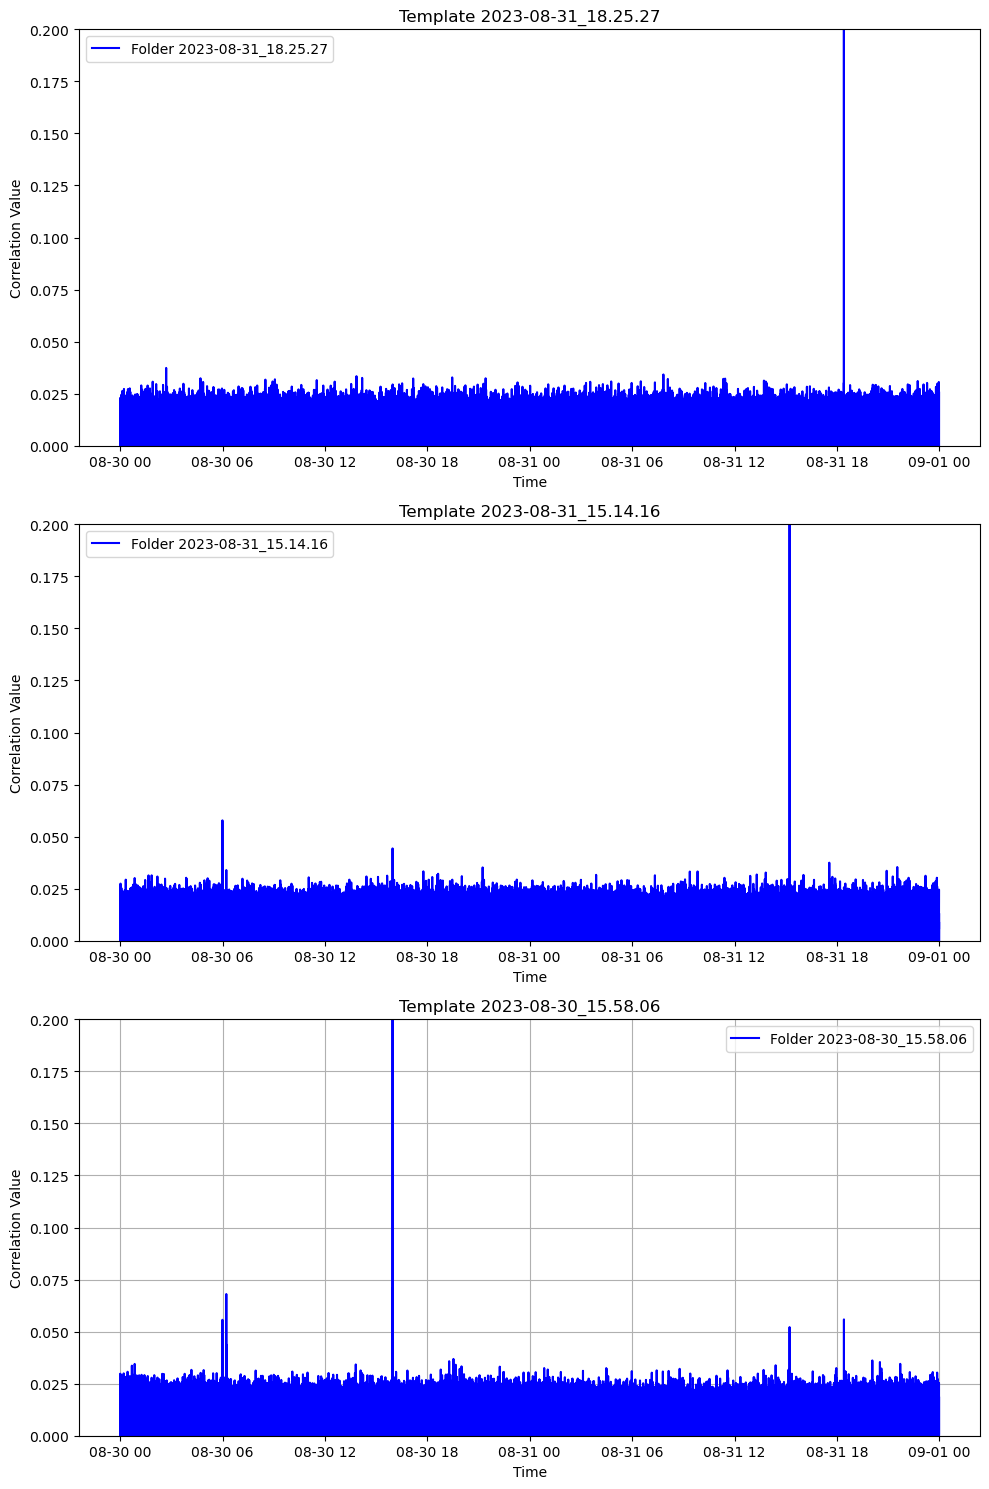

In [26]:
# Inicializar una lista para almacenar los datos concatenados por cada carpeta
concatenated_data_per_folder = []

# Iterar sobre las carpetas y cargar los archivos .npy
for folder in folders:
    folder_path = os.path.join(base_directory, folder)
    npy_files = load_npy_files(folder_path)
    concatenated_data_per_folder.append(np.concatenate(npy_files, axis=0))

# Graficar los datos para cada carpeta
fig, axs = plt.subplots(len(folders), 1, figsize=(10, 5*len(folders)))

for i, folder_data in enumerate(concatenated_data_per_folder):
    axs[i].plot(time_range, folder_data, label=f'Folder {folders[i]}', color='blue', linestyle='-')
    axs[i].set_title(f'Template {folders[i]}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Correlation Value')
    axs[i].legend()  # Add legend to each subplot
    axs[i].set_ylim([0,0.2])  # Set y-axis limits from 0 to 0.5


plt.tight_layout()
plt.grid()
plt.show()

In [27]:
#add thresold and detections stuff